In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../models/')
outdir = Path('../figures/v2-batch-t=0.01/')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'fitting', False: 'cross-validation'
})
results_df = results_df.sort_values(['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair'])
results_df['sparsity coefficient'] = results_df['lambda'].astype(str)

# results_df = results_df[results_df['rank'].le(50)]
results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,css_cv_factor0,scss_cv_factor0,genus,comparison,sparsity coefficient
234,0,1,0.0,A,A,"A, A",1,5084.00,0.844591,NaN,NaN,NaN,pro,fitting,0.0
235,0,1,0.0,A,B,"A, B",1,5084.00,1.190993,0.048667,0.296669,1.0,pro,cross-validation,0.0
236,0,1,0.0,A,C,"A, C",1,5084.00,1.143894,0.009977,0.767461,1.0,pro,cross-validation,0.0
237,0,1,0.0,B,A,"B, A",1,5084.00,0.879580,NaN,NaN,NaN,pro,cross-validation,0.0
238,0,1,0.0,B,B,"B, B",1,5084.00,0.853443,NaN,NaN,NaN,pro,fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7798,9,50,100.0,B,B,"B, B",0,0.00,1.000000,NaN,NaN,NaN,syn,fitting,100.0
7799,9,50,100.0,B,C,"B, C",0,0.00,1.000000,0.000000,0.000000,0.0,syn,cross-validation,100.0
7800,9,50,100.0,C,A,"C, A",1,0.02,0.999945,NaN,NaN,NaN,syn,cross-validation,100.0
7801,9,50,100.0,C,B,"C, B",1,0.02,0.999919,NaN,NaN,NaN,syn,cross-validation,100.0


# Plot cross-validation data

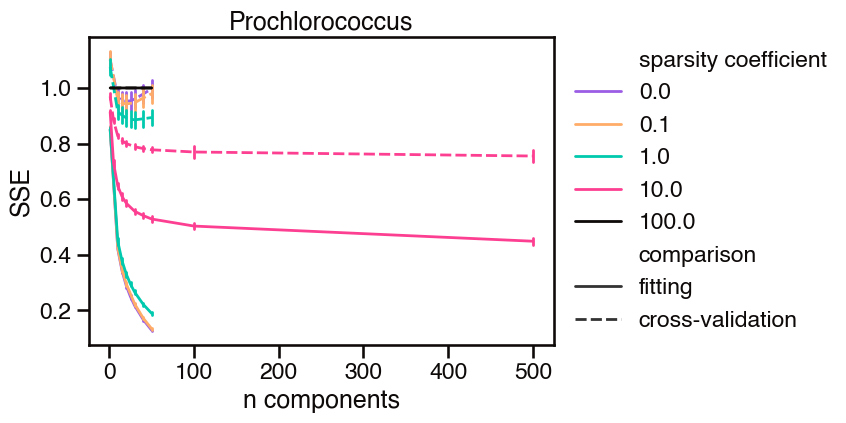

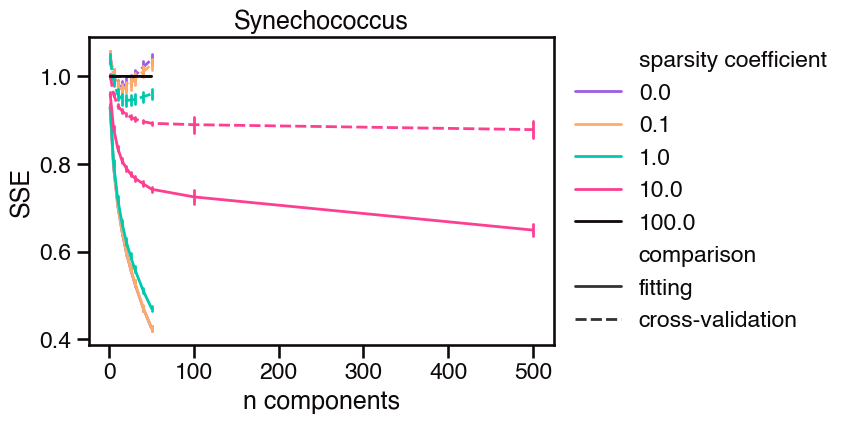

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 40, 50, 100, 500])]
#     plot_df = plot_df[plot_df['rank'].isin([1, 10, 15, 20, 25, 30, 40, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    # for i, lamb in enumerate(plot_df['lambda'].unique()):
    #     data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='sparsity coefficient', 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    #     label=lamb, 
    );

    # plt.xlim([0.6, 12.4])
    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('n components');
    plt.ylabel('SSE')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')
    plt.show()


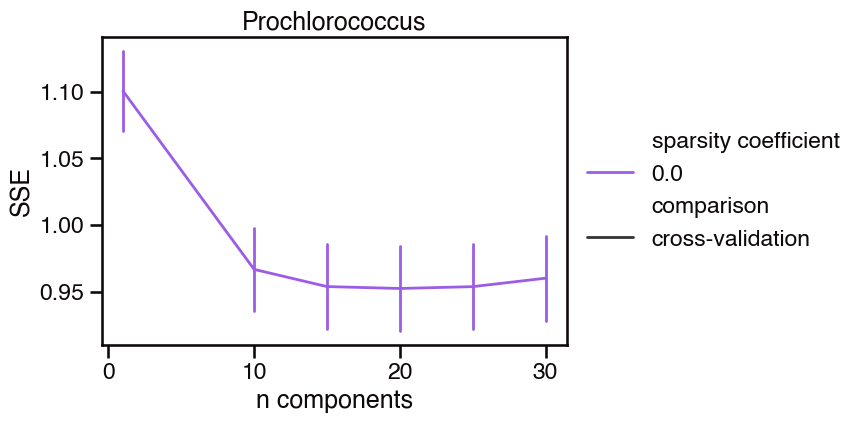

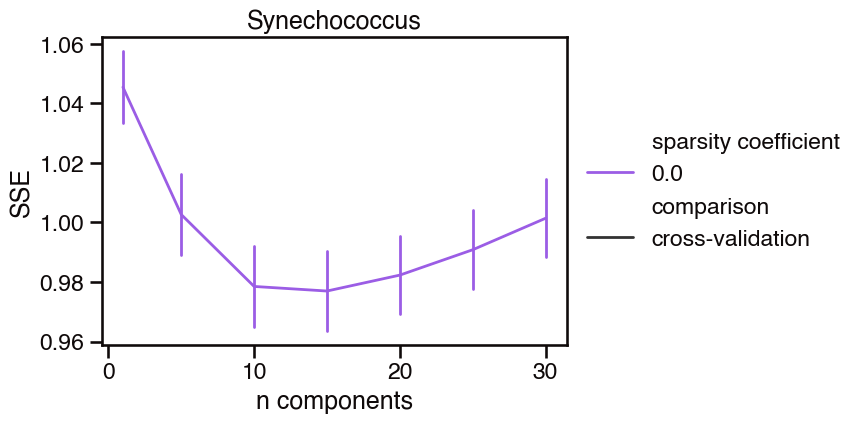

In [5]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['lambda'].isin([0.])]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30])]
#     plot_df = plot_df[plot_df['bootstrap_id'].isin([0])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    # for i, lamb in enumerate(plot_df['lambda'].unique()):
    #     data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='sparsity coefficient', 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    #     label=lamb, 
    );

    # plt.xlim([0.6, 12.4])
    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('n components');
    plt.ylabel('SSE')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
#     plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')
    plt.show()
    

In [12]:
# find minimum SSE

summary_df = results_df[results_df['comparison'] == 'cross-validation']
summary_df = summary_df[summary_df['lambda'].isin([0])]
summary_df = summary_df[summary_df['rank'].isin([1, 5, 10, 15, 20, 25, 30])]
# summary_df = summary_df[summary_df['genus'].isin(['pro'])]
summary_df.groupby(['genus', 'rank', 'lambda'])['mean_gene_sparsity', 'relative_sse', 'fms_cv'].agg(
        mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
        relative_sse=('relative_sse', 'mean'), 
        fms_cv=('fms_cv', 'mean'), 
        bootstraps=('fms_cv', 'count')
    ).sort_values(
    ['genus', 'relative_sse'], ascending=True
#     ['genus', 'fms_cv'], ascending=False
).tail(50)


mean_gene_sparsity  relative_sse    fms_cv  bootstraps
genus rank lambda                                                        
pro   20   0.0                 5084.0      0.952379  0.210743          15
      25   0.0                 5084.0      0.953749  0.199398          15
      15   0.0                 5084.0      0.953795  0.329900          15
      30   0.0                 5084.0      0.960098  0.189684          15
      10   0.0                 5084.0      0.966712  0.319631          15
      1    0.0                 5084.0      1.100594  0.055679          15
syn   15   0.0                 6161.0      0.976975  0.295976          30
      10   0.0                 6161.0      0.978516  0.375866          30
      20   0.0                 6161.0      0.982328  0.217688          30
      25   0.0                 6161.0      0.990849  0.216521          30
      30   0.0                 6161.0      1.001435  0.201112          30
      5    0.0                 6161.0      1.002681  0.362869          30
      1    0.0                 6161.0      1.045475  0.047658          30

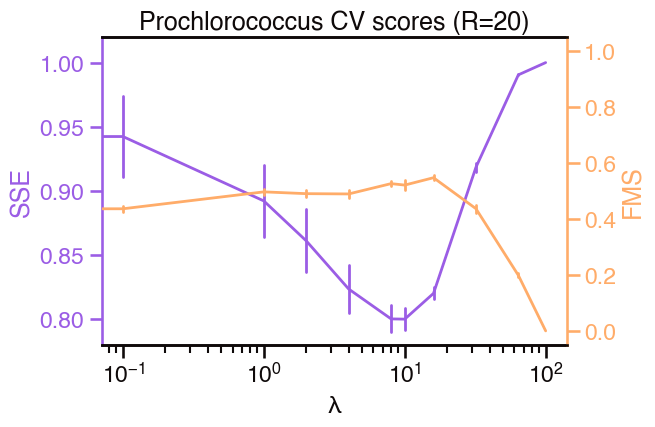

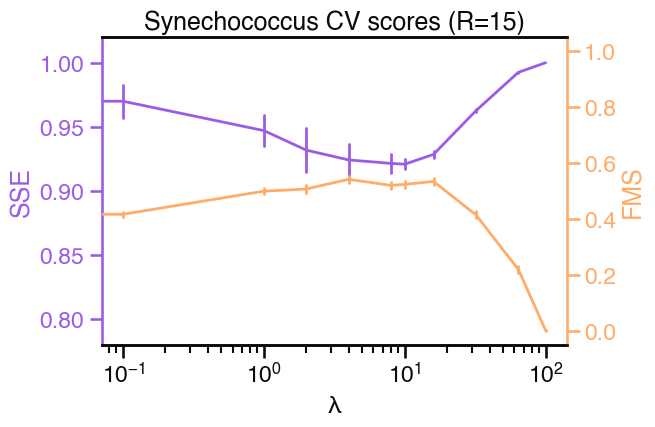

In [9]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 20, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='λ', ylabel='SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='λ', ylabel='FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


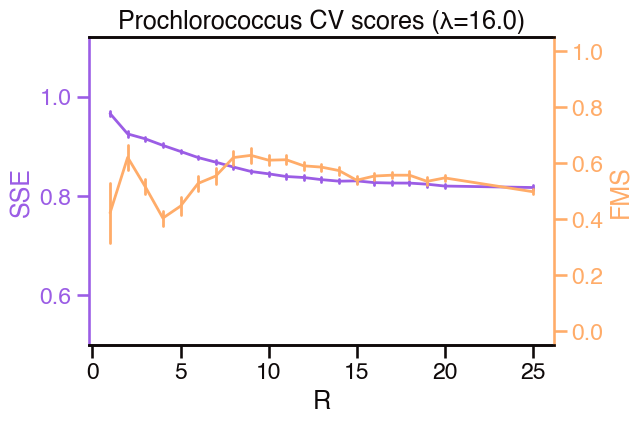

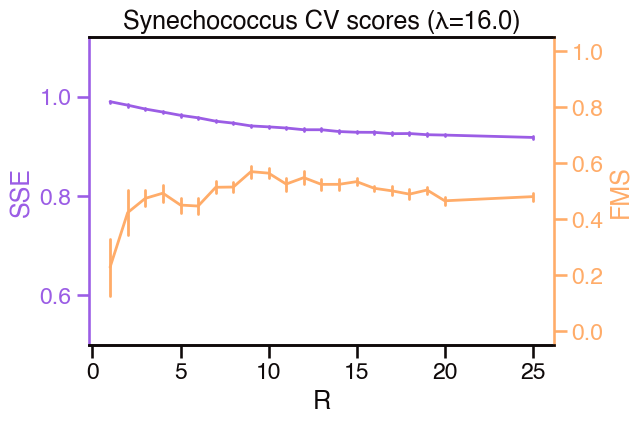

In [13]:
# look at SSE and FMS vs rank

# define data
lamb = 16.0

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb));
    plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


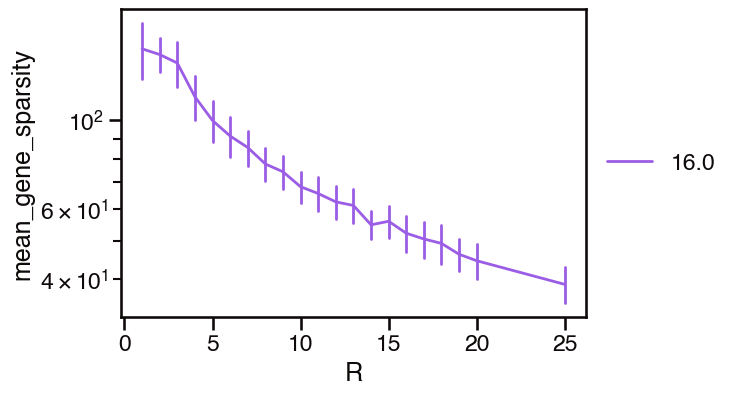

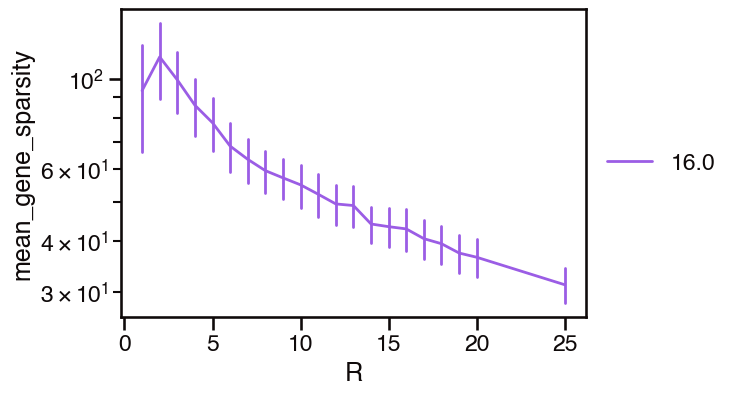

In [15]:
# look at number of nonzero components with rank

# define data
lamb = 16.0
for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'fitting']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    # for i, lamb in enumerate(plot_df['lambda'].unique()):
    #     data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='sparsity coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    #     label=lamb, 
    );

    # plt.xlim([0.6, 12.4])
    plt.xlabel('R');
    plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
